<a href="https://colab.research.google.com/github/LauraP63/Evaluate-Improve-Models/blob/master/Projet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 - Rappel du contexte et requêtes utilisées

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique.
Pour poser une question sur ce site, il faut entrer plusieurs tags afin de retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous **développez un système de suggestion de tags pour le site**. Celui-ci prendra la forme d’un algorithme de machine learning qui a**ssignera automatiquement plusieurs tags pertinents à une question.**

Contraintes :
<ul>
<li>Appliquer des méthodes d’extraction de features spécifiques des données 
textuelles.</li>
<li>Mettre en œuvre une approche non supervisée afin de proposer des mots clés.
Mettre en œuvre une approche purement supervisée et comparer les résultats avec l’approche non supervisée. Plusieurs méthodes d’extraction de features seront testées et comparées ; au minimum :
une approche de type bag-of-words ;
3 approches de Word/Sentence Embedding : Word2Vec (ou Doc2Vec, Glove…), BERT et USE. <li>
<li>
Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.</li>
<li>Utiliser un logiciel de gestion de versions, par exemple Git, pour suivre les modifications du code final à déployer.</li>

📁  Pour ce projet on se basera sur : 

*   Les publications de type question (pas leurs réponses)
*   Les questions qui ont au minimum 3 tags
*   Les questions qui ont un nombre suffisants de vue (+ de 10) afin de ne pas inclure de potentielles questions hors sujet ou mal classifiées
*   Les questions qui ont connu une activité récente (de mars 2022 à 2023) afin d'inclure des technologies récentes et d'exclure potentiellement les vieux sujets et les technologies obsolètes





🔎 ex de requête utilisée avec découpage en plusieurs périodes pour contourner les 50000 rep maximum. On obtient au final près de 120 000 lignes.



```
SELECT TOP 50000 Title, Body, Tags, p.Id, p.Score, ViewCount, FavoriteCount, AnswerCount
FROM Posts p 
WHERE PostTypeId = 1 AND ViewCount > 10 
AND p.Score > 5 AND p.AnswerCount > 0 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 3
AND p.LastActivityDate < '2022-07-01' AND p.LastActivityDate > '2022-04-01'
```



# I - Chargement des bibliothèques et fichiers

In [1]:
# instalaltion de pandaraller pour faire tourner
# les algos en // sur plusieurs processeurs
!pip install pandarallel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 4.2 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.4-py3-none-any.whl size=16677 sha256=c9af0ee3cd6ce838ee07c9d590509969794bf7e62f7db85be53c6fb1659ee4a0
  Stored in directory: /root/.cache/pip/wheels/41/01/29/deaa71fe596f8d857e57c4fb388db8861e23e6ed0b03204dcb
Successfully built pandarallel


In [2]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 29.5 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


In [3]:
# importation des bibliothèques utiles au projet
import pandas as pd
import numpy as np
from google.colab import files #pour le chargement du csv
import re # pour les  regex
import string
import nltk
import os, sys, time

import numpy as np
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim

#pour les affichages graphiques
import seaborn as sns
import matplotlib.pyplot as plt

#pour les imputer Sickit learn
from sklearn.impute import KNNImputer
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn import neighbors, metrics
from sklearn import preprocessing

#pour l'analyse textuelle
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import words, stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
from PIL import Image
from pandarallel import pandarallel


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
pandarallel.initialize(progress_bar=True,
                       nb_workers=6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# chargement des fichiers
data1 = pd.read_csv('QueryResults042022.csv',  low_memory=False)
data2 = pd.read_csv('QueryResults072022.csv',  low_memory=False)
data3 = pd.read_csv('QueryResults102022.csv',  low_memory=False)
data4 = pd.read_csv('QueryResults2023.csv',  low_memory=False)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# concatenation des différents fichiers obtenus par les requêtes
# (regroupement des différentes périodes depuis mars 2022 à mars 2023)
data_global = pd.concat([data1, data2, data3, data4])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# on obtient 119176 lignes et 8 colonnes
data_global.shape

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(119176, 8)

In [18]:
data_global.head(10)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,CSS transforms VS transitions,<p>What are the key differences between CSS tr...,<css><css-transitions><css-transforms>,19186585,41,23368,0.0,2
1,Gradle Daemon could not be reused,<p>I am trying to run a react native project b...,<react-native><gradle><gradle-daemon>,57360563,6,20610,NaN,1
2,IDE for Swing applications development,<p>Is there any IDE that simplifies creating S...,<java><swing><ide>,26458,47,33422,0.0,31
3,Getting all types that implement an interface,"<p>Using reflection, how can I get all types t...",<c#><optimization><reflection><lambda><c#-3.0>,26733,649,361596,0.0,19
4,Why aren't Enumerations Iterable?,<p>In Java 5 and above you have the foreach lo...,<java><enumeration><iterable>,27240,67,21093,0.0,6
5,AWS Athena - GENERIC_INTERNAL_ERROR: Number of...,<p>I'm querying a table in Athena that is givi...,<amazon-web-services><aws-glue><presto><amazon...,56979292,14,10691,0.0,2
6,What's the difference between a temp table and...,"<p>In SQL Server 2005, we can create temp tabl...",<sql-server><temp-tables><table-variable>,27894,422,407580,0.0,13
7,How do you set up an OpenID provider (server) ...,<p>I want to log onto Stack Overflow using Ope...,<linux><ubuntu><openid>,28588,14,12313,0.0,6
8,VBA paste range,<p>I would like to copy a range and paste it i...,<excel><vba><range><paste>,18968856,7,193428,0.0,4
9,Is there a shorthand for smaller than AND grea...,<p>Is there a shorthand for this:</p>\n\n<pre>...,<c#><expression><shorthand>,37721722,7,5443,0.0,3


In [10]:
data_global.tail(10)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
33123,How to show and hide some columns on React Table?,<p>I have created a React Table. I want to hid...,<reactjs><react-table><react-table-v6>,53638095,36,77245,0.0,2
33124,Supported fonts in HTML5 Canvas text,<p>With the HTML Canvas API we can draw text u...,<javascript><html><html5-canvas>,53638179,15,11746,0.0,1
33125,Allow Legacy Renegotiation for NodeJs,<p>The best way to solve this would be to upda...,<node.js><linux><soap><openssl>,74324019,6,3356,NaN,1
33126,Vue.js - Use filter inside v-for,<p>I have a simple Vue filter that limits the ...,<javascript><vue.js><vuejs2><vue-component><v-...,53639575,8,22913,0.0,3
33127,go_router and flutter_bloc: Unhandled Exceptio...,<p>I have wrapped the MaterialApp with a BlocP...,<flutter><flutter-bloc><flutter-go-router>,74327180,7,1619,NaN,2
33128,Why does sending via a UdpClient cause subsequ...,<p>I'm trying to create a UDP server which can...,<c#><udp><udpclient>,74327225,101,6103,NaN,2
33129,Custom callback after each epoch to log certai...,"<p>I know how to <a href=""https://keras.rstudi...",<python><machine-learning><keras>,53640596,6,3510,NaN,3
33130,Only Android Application Modules can be connec...,<p>In Android Studio 3.2.1 I select:<br>\nNew ...,<firebase><android-studio><dart><flutter>,53640729,8,12157,0.0,1
33131,Pandas Merging 101,<ul>\n<li>How can I perform a (<code>INNER</co...,<python><pandas><join><merge><concatenation>,53645882,867,365582,0.0,8
33132,Elevation in React Native,<p>Here is my style defined in the React-Nativ...,<css><react-native><border><shadow><elevation>,53647304,11,74723,0.0,5


In [11]:
data_global.sample(10)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
18398,TypeError: 'Column' object is not callable usi...,<p>I would like append a new column on datafra...,<apache-spark><pyspark><apache-spark-sql>,48305443,11,123006,0.0,2
13762,Setting specific permission in amazon s3 boto ...,<p>I have a bucket called 'ben-bucket' inside ...,<python><amazon-s3><boto>,40518642,6,13373,0.0,1
12957,Emulate Samsung Galaxy Tab,<p>I would like to test my application with ne...,<android><android-emulator><tablet>,3745491,69,115804,0.0,7
8516,Find element that is causing the showing of ho...,<p>When I size my Chrome window to 328 x 455 p...,<css><scrollbar><overflow>,31458477,130,68846,0.0,12
29585,Optimizing smooth tween between svg paths in J...,<p>I'm currently porting an application to Rea...,<javascript><react-native><performance><animat...,75274256,8,255,NaN,1
16694,Why does 'man 2 open' say that there are two k...,<p>I ran into this question while typing <code...,<c><linux><overloading><manpage>,3953895,17,734,0.0,3
25981,VS Code auto generate interface methods in php...,"<p>How can i ""auto implement""/generate methods...",<php><methods><interface><visual-studio-code><...,54883976,11,9732,NaN,3
29890,How do you stop Prettier in VS code splitting ...,<p>I am using prettier to format my code in VS...,<html><visual-studio-code><formatting><prettier>,56291245,72,41555,0.0,10
29373,@Disabled is not working in JUnit5,<p>I want to use Junit 5 in Maven project:</p>...,<java><eclipse><junit5>,52054577,14,9816,NaN,4
22076,Mockito ClassCastException - A mock cannot be ...,<p>I have a method in the class <code>ApplePro...,<java><mocking><mockito>,28462611,24,71854,0.0,5


🎯 on peut déjà identifier notre target : Tags

# II - EDA

## A) Analyse globale / Recherche d'erreurs

### Valeurs manquantes

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

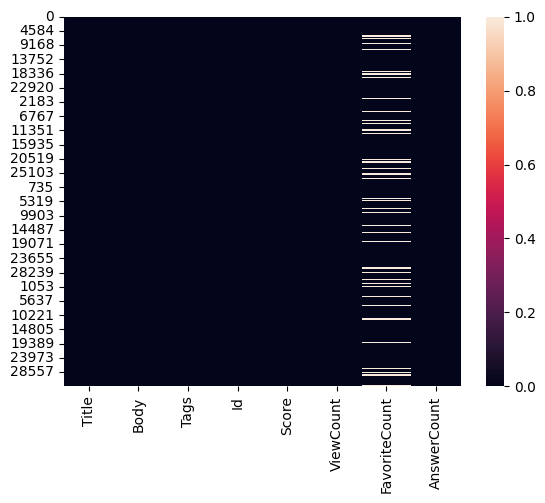

In [19]:
sns.heatmap(data_global.isna())

In [20]:
data_global['FavoriteCount'].unique()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 0., nan,  1.,  2.])

🔎  La target n'a pas de valeurs manquantes. Quelques NAN dans les favoriteCount.. On va les imputer à 0 : pas de mise en favoris = 0 favori sur la question

In [21]:
data_global = data_global.fillna(0)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
data_global.isnull().sum()
# plus de valeurs manquantes

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Title            0
Body             0
Tags             0
Id               0
Score            0
ViewCount        0
FavoriteCount    0
AnswerCount      0
dtype: int64

### Doublons

In [120]:
# recherche de lignes dupliquées
data_global.duplicated().sum()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0

In [17]:
# recherche de variables dupliquées dans les colonnes
for col in data_global.columns :
  n = data_global.duplicated(subset=col).sum()
  print(f"col : {col} ->duplicated : {n}")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


col : Title ->duplicated : 3
col : Body ->duplicated : 0
col : Tags ->duplicated : 17329
col : Id ->duplicated : 0
col : Score ->duplicated : 117401
col : ViewCount ->duplicated : 49014
col : FavoriteCount ->duplicated : 119173
col : AnswerCount ->duplicated : 119076


🔎 on a 'logiquement' quelques variables numériques dupliquées comme le score ou le ViewCount ainsi que dans la target puisque des tags peuvent être utilisés dans plusieurs questions.
En revanche, on a aussi 3 duplicates dans les titles que l'on va afficher.

In [23]:
idx = data_global.duplicated(subset="Title", keep=False)
data_global.loc[idx, :].sort_values("Title")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
5225,ERROR: Error installing ffi: ERROR: Failed to ...,<p>Got the DevKit installed and re-ran the ffi...,<ruby><rubygems><ffi>,7852566,29,73058,0.0,17
21994,ERROR: Error installing ffi: ERROR: Failed to ...,<p>I am getting this error in Mac 64 bit and h...,<macos><file><makefile><ffi>,5625997,22,22849,0.0,13
2452,The request was aborted: Could not create SSL/...,<p>My customer has informed my of issues with ...,<c#><asp.net><ssl><httpwebrequest>,10822509,82,201435,0.0,14
13883,The request was aborted: Could not create SSL/...,<p>We are unable to connect to an HTTPS server...,<c#><asp.net><windows-8><windows-7><httpwebreq...,2859790,676,1364023,0.0,49
7092,Unable to find the requested .Net Framework Da...,<p>After completing the ASP.NET MVC 3 tutorial...,<asp.net><asp.net-mvc><asp.net-mvc-3><deployment>,16165158,7,43206,0.0,5
7969,Unable to find the requested .Net Framework Da...,<p>Hi it is my first time that I publish a pro...,<c#><asp.net><.net><entity-framework>,21157069,17,71467,0.0,10


🔎 il s'agit de questions différentes qui portent sur le même sujet. On constate par ailleurs qu'elles n'ont pas les mêmes tags. On conserve ces titres en doublon.

In [19]:
data_global.describe(include=object)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Body,Tags
count,119176,119176,119176
unique,119173,119176,101847
top,The request was aborted: Could not create SSL/...,<p>What are the key differences between CSS tr...,<python><pandas><dataframe>
freq,2,1,163


### Outliers

In [20]:
# distribution des valeurs numériques 
# /!\ long en exécution
# for col in data_global.select_dtypes(include=np.number):
#     plt.figure()
#     sns.boxplot(data_global[col])


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## B) Analyse univariée

### Visualisation de la target


In [24]:
# on compte le nombre de tags par sujet
# à l'aide de leur séparateur '<>'
data_global['Tags_count'] = data_global['Tags'].str.count('<')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


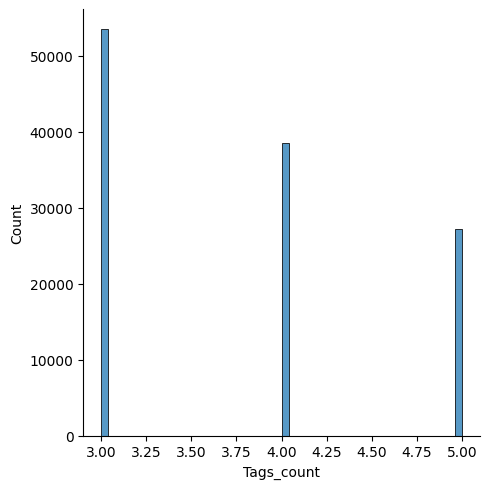

In [22]:
sns.displot(data_global['Tags_count'])

🔎 3 (majoritaires) à 5 tags par question

In [23]:
data_global.head(10)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,Tags_count
0,CSS transforms VS transitions,<p>What are the key differences between CSS tr...,<css><css-transitions><css-transforms>,19186585,41,23368,0.0,2,3
1,Gradle Daemon could not be reused,<p>I am trying to run a react native project b...,<react-native><gradle><gradle-daemon>,57360563,6,20610,0.0,1,3
2,IDE for Swing applications development,<p>Is there any IDE that simplifies creating S...,<java><swing><ide>,26458,47,33422,0.0,31,3
3,Getting all types that implement an interface,"<p>Using reflection, how can I get all types t...",<c#><optimization><reflection><lambda><c#-3.0>,26733,649,361596,0.0,19,5
4,Why aren't Enumerations Iterable?,<p>In Java 5 and above you have the foreach lo...,<java><enumeration><iterable>,27240,67,21093,0.0,6,3
5,AWS Athena - GENERIC_INTERNAL_ERROR: Number of...,<p>I'm querying a table in Athena that is givi...,<amazon-web-services><aws-glue><presto><amazon...,56979292,14,10691,0.0,2,4
6,What's the difference between a temp table and...,"<p>In SQL Server 2005, we can create temp tabl...",<sql-server><temp-tables><table-variable>,27894,422,407580,0.0,13,3
7,How do you set up an OpenID provider (server) ...,<p>I want to log onto Stack Overflow using Ope...,<linux><ubuntu><openid>,28588,14,12313,0.0,6,3
8,VBA paste range,<p>I would like to copy a range and paste it i...,<excel><vba><range><paste>,18968856,7,193428,0.0,4,4
9,Is there a shorthand for smaller than AND grea...,<p>Is there a shorthand for this:</p>\n\n<pre>...,<c#><expression><shorthand>,37721722,7,5443,0.0,3,3


In [44]:
data_global['Tags_clean'] =  data_global['Tags'].str.replace('<', ' ')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
data_global['Tags_clean'] =  data_global['Tags_clean'].str.replace('>', ' ')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
print(data_global['Tags_clean'].sample(30))

5864      javascript  html  security  content-security-...
8405                                list  haskell  syntax 
475       django  orm  many-to-many  one-to-one  many-t...
28888                            node.js  angular  vue.js 
13207     arrays  algorithm  data-structures  dynamic-p...
23447                       c#  ios  objective-c  xamarin 
3631                     android  ios  text  react-native 
24345                   python  python-3.x  ssh  paramiko 
20783                             vpn  openvpn  azure-vpn 
14053     android  android-fragments  android-popupwindow 
5229                              javascript  ios  sentry 
21885                                 go  build  go-build 
10072                      git  ssh  ssh-keys  public-key 
6483                  git  merge  branch  code-formatting 
10515                   git  version-control  ssh  cygwin 
14655                          php  file  upload  numbers 
25623                         java  maven  junit4  junit

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
tags_popularity = data_global['Tags_clean'] .values.tolist()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
tags_popularity_string = ''.join(str(x) for x in tags_popularity)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
from wordcloud import WordCloud


# Instantiate / create a new wordcloud.
wordcloud = WordCloud(
    random_state = 8,
    normalize_plurals = False,
    width = 600,
    height= 300,
    collocations=False,
    max_words = 300
   
)

# Apply the wordcloud to the text.
wordcloud.generate(tags_popularity_string)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.5, 599.5, 299.5, -0.5)

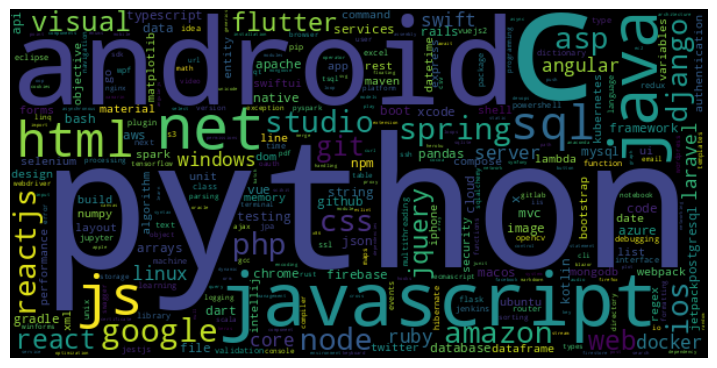

In [50]:
# Import matplotlib
import matplotlib.pyplot as plt

# create a figure
fig, ax = plt.subplots(1,1, figsize = (9,6))


# add interpolation = bilinear to smooth things out
plt.imshow(wordcloud, interpolation='bilinear')

# and remove the axis
plt.axis("off")

In [32]:
# affichage des tags les moins populaires
# source : https://stackoverflow.com/questions/52137480/less-frequent-words-appearing-bigger-wordcloud-in-python
def invert_wc(wc):
    keys = list(wc.words_.keys())
    values = list(wc.words_.values())
    values.reverse()
    wc.words_ = dict(zip(keys, values))
    return wc

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
wordcloud =  invert_wc(wordcloud)
wordcloud.generate_from_frequencies(wordcloud.words_)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.5, 599.5, 299.5, -0.5)

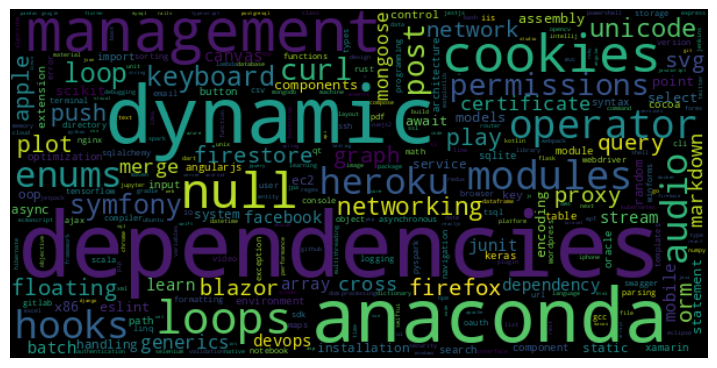

In [40]:
# creation du nuage de mots
fig, ax = plt.subplots(1,1, figsize = (9,6)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [41]:
tags = data_global['Tags'].str.split()
tags_total_counts = pd.value_counts(tags.apply(pd.Series).stack())

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
print('Le DF comporte' , tags_total_counts.sum() , ' tags')

Le DF comporte 450465  tags


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


🔍Le dataframe initial comporte 450 465 tags uniue. On devra réduire ce chiffre pour les algos d'apprentissage supervisés.

### Visualisation des features

In [31]:
# Data inspection
data_global.describe(include=np.number)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Id,Score,ViewCount,FavoriteCount,AnswerCount,Tags_count
count,1.191760e+05,119176.000000,1.191760e+05,119176.000000,119176.000000,119176.000000
mean,3.380169e+07,73.531105,8.621143e+04,0.000117,6.150039,3.779830
std,2.229730e+07,289.084752,2.435359e+05,0.011586,6.358512,0.792782
min,4.000000e+00,6.000000,3.800000e+01,0.000000,1.000000,3.000000
25%,1.262731e+07,9.000000,8.289750e+03,0.000000,3.000000,3.000000
50%,3.428350e+07,18.000000,2.314900e+04,0.000000,4.000000,4.000000
75%,5.279632e+07,51.000000,7.115025e+04,0.000000,7.000000,4.000000
max,7.577435e+07,26918.000000,1.248917e+07,2.000000,133.000000,5.000000


🔎 nombreuses vues et réponses mais qui ne semblent pas aberrantes vis à vis de la popularité du site

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


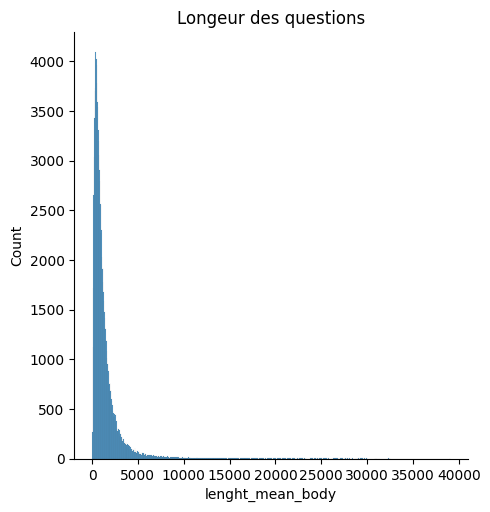

In [32]:
data_global['lenght_mean_body'] = data_global.Body.str.len()
sns.displot(data_global['lenght_mean_body']).set(title='Longeur des questions')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


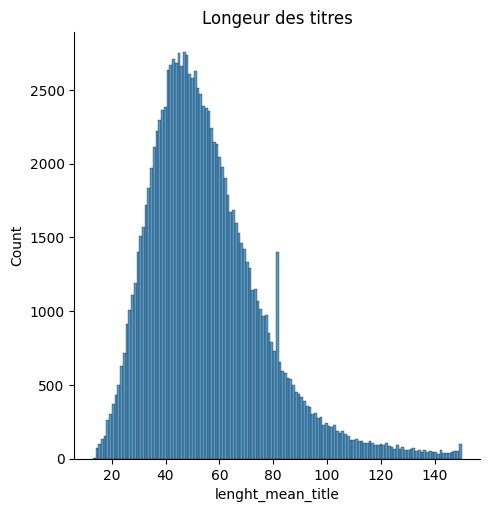

In [33]:
data_global['lenght_mean_title'] = data_global.Title.str.len()
sns.displot(data_global['lenght_mean_title']).set(title='Longeur des titres')

### Première visualisation des données textes

In [34]:
# selection d'un échantillon de questions 
doc = data_global.Body.sample(10000)
doc = doc.values[:5]
doc

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['<p>I\'ve been trying to figure out how to map a set of characters in a string to another set similar to the <code>tr</code> function in Perl. </p>\n\n<p>I found <a href="http://www.lemoda.net/perl/perl-js/perl-js.html">this site that shows equivalent functions in JS and Perl</a>, but sadly no tr equivalent. </p>\n\n<p>the <code>tr</code> (transliteration) function in Perl maps characters one to one, so</p>\n\n<pre><code>     data =~ tr|\\-_|+/|;\n</code></pre>\n\n<p>would map </p>\n\n<pre><code>     - =&gt; + and _ =&gt; /\n</code></pre>\n\n<p>How can this be done efficiently in JavaScript?</p>\n',
       "<p>I'm currently working through some Azure Container App quick starts. I've just attempted to create one that's Dapr enabled with storage account state store. It has a provision status of failed but seemingly no other information. I'm not aware of how to access any logs from the container and there's nothing in the Log Analytics workspace. The others examples I've tested hav

🔍 on peut voir qu'on est sur des données brutes avec les balises HTML. On a également des exemples de code imbriqués dans les messages qu'on va devoir probablement supprimer car ils peuvent donner de fausses informations sur le sujet initial du message. Enfin on aura d'autres opérations de nettoyage à réaliser (élimination des stopwords, tokenization, lemmatization) pour poursuvire l'analyse avec les données textuelles.

In [35]:
from bs4 import BeautifulSoup
data_global['Body_bs']=data_global['Body'].apply(lambda x: BeautifulSoup(x)) 

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
data_global.head(30)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,Tags_count,lenght_mean_body,lenght_mean_title,Body_bs
0,CSS transforms VS transitions,<p>What are the key differences between CSS tr...,css css-transitions css-transforms,19186585,41,23368,0.0,2,3,279,29,[[[<p>What are the key differences between CSS...
1,Gradle Daemon could not be reused,<p>I am trying to run a react native project b...,react-native gradle gradle-daemon,57360563,6,20610,0.0,1,3,1656,33,[[[<p>I am trying to run a react native projec...
2,IDE for Swing applications development,<p>Is there any IDE that simplifies creating S...,java swing ide,26458,47,33422,0.0,31,3,121,38,[[[<p>Is there any IDE that simplifies creatin...
3,Getting all types that implement an interface,"<p>Using reflection, how can I get all types t...",c# optimization reflection lambda c#-3.0,26733,649,361596,0.0,19,5,316,45,"[[[<p>Using reflection, how can I get all type..."
4,Why aren't Enumerations Iterable?,<p>In Java 5 and above you have the foreach lo...,java enumeration iterable,27240,67,21093,0.0,6,3,929,33,[[[<p>In Java 5 and above you have the foreach...
5,AWS Athena - GENERIC_INTERNAL_ERROR: Number of...,<p>I'm querying a table in Athena that is givi...,amazon-web-services aws-glue presto amazon...,56979292,14,10691,0.0,2,4,803,96,[[[<p>I'm querying a table in Athena that is g...
6,What's the difference between a temp table and...,"<p>In SQL Server 2005, we can create temp tabl...",sql-server temp-tables table-variable,27894,422,407580,0.0,13,3,433,76,"[[[<p>In SQL Server 2005, we can create temp t..."
7,How do you set up an OpenID provider (server) ...,<p>I want to log onto Stack Overflow using Ope...,linux ubuntu openid,28588,14,12313,0.0,6,3,379,56,[[[<p>I want to log onto Stack Overflow using ...
8,VBA paste range,<p>I would like to copy a range and paste it i...,excel vba range paste,18968856,7,193428,0.0,4,4,479,15,[[[<p>I would like to copy a range and paste i...
9,Is there a shorthand for smaller than AND grea...,<p>Is there a shorthand for this:</p>\n\n<pre>...,c# expression shorthand,37721722,7,5443,0.0,3,3,198,62,"[[[<p>Is there a shorthand for this:</p>, \n, ..."


In [37]:
data_global['Body_code']=data_global['Body_bs'].apply(lambda x: x.find_all("code")) 

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
data_global['Body_message']=data_global['Body_bs'].apply(lambda x: x.find_all("p")) 

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# selection d'un échantillon de questions 
doc = data_global.Body_message.sample(10000)
doc = doc.values[:5]
doc

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[<p>I computed the smallest and largest pixel values for pixel in a grayscale image as follows:</p>, <p>but this will only works in grayscale.</p>, <p>How can I do the same for a color image (RGB)?</p>],
       [<p>Can someone help me with this? I'm feeling like I've been hitting my head against a wall for over 2 hrs now.</p>, <p>I've got <code>Apache 2.2.8 + PHP 5.2.6</code> installed on my machine and the <code>.htaccess</code> with the code below works fine, no errors.</p>, <p>The same code on my hosting provider server gives me a 404 error code and outputs <code>only: No input file specified.</code> index.php is there. I know they have Apache installed (cannot find version info anywhere) and they're running PHP v5.2.8.</p>, <p>I'm on <code>Windows XP 64-bit</code>, they're running some <code>Linux</code> with <code>PHP</code> in <code>CGI/FastCGI</code> mode. Can anyone suggest what could be the problem?</p>, <p>PS. if that's important that's for <code>CodeIgniter</code> to 

In [126]:
doc = data_global.Body_code.sample(10000)
doc = doc.values[:5]
doc

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: ignored

In [41]:
# Apply the wordcloud to the text.
values = ','.join(str(v) for v in data_global.Body_code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
wordcloud.generate(values)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.5, 599.5, 299.5, -0.5)

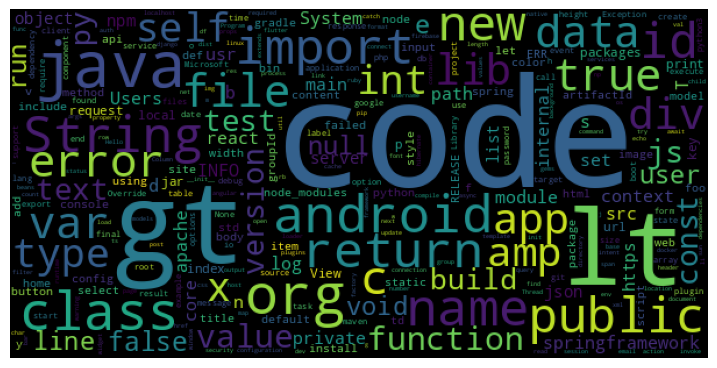

In [43]:
# create a figure
fig, ax = plt.subplots(1,1, figsize = (9,6))


# add interpolation = bilinear to smooth things out
plt.imshow(wordcloud)

# and remove the axis
plt.axis("off")

In [44]:
valuesText = ','.join(str(v) for v in data_global.Body_message)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
wordcloud.generate(valuesText)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.5, 599.5, 299.5, -0.5)

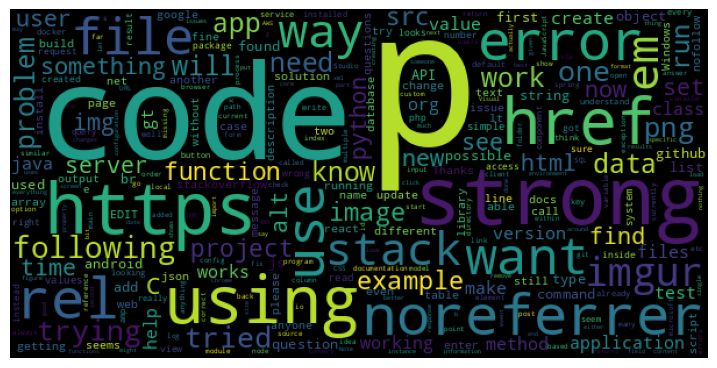

In [46]:
fig, ax = plt.subplots(1,1, figsize = (9,6))


# add interpolation = bilinear to smooth things out
plt.imshow(wordcloud)

# and remove the axis
plt.axis("off")

🔍 Les parties de code peuvent donner des indications supplémentaires sur les langages et technos utilisés (kw). On pourra donc conserver ces parties en effectuant aussi du nettoyage/preprocessing.

##C)  Analyse multivariée

### HeatMap des corrélations


In [47]:
corr = data_global.corr()
corr

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Id,Score,ViewCount,FavoriteCount,AnswerCount,Tags_count,lenght_mean_body,lenght_mean_title
Id,1.000000,-0.196503,-0.252094,-0.002397,-0.312287,0.067823,0.204731,0.234087
Score,-0.196503,1.000000,0.753638,0.142638,0.462680,0.003926,-0.060702,-0.035105
ViewCount,-0.252094,0.753638,1.000000,0.084147,0.552556,-0.011379,-0.074935,-0.056196
FavoriteCount,-0.002397,0.142638,0.084147,1.000000,0.035525,-0.000838,-0.004610,-0.001180
AnswerCount,-0.312287,0.462680,0.552556,0.035525,1.000000,-0.019439,-0.063123,-0.038395
Tags_count,0.067823,0.003926,-0.011379,-0.000838,-0.019439,1.000000,0.105945,0.088572
lenght_mean_body,0.204731,-0.060702,-0.074935,-0.004610,-0.063123,0.105945,1.000000,0.172148
lenght_mean_title,0.234087,-0.035105,-0.056196,-0.001180,-0.038395,0.088572,0.172148,1.000000


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

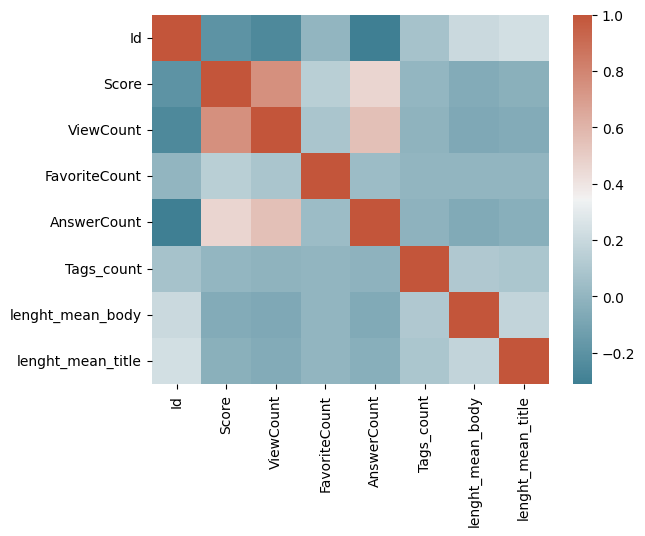

In [48]:
sns.heatmap(corr, cmap=sns.diverging_palette(220, 20, as_cmap=True))

🔎 Corrélation assez logique entre le viewcount et le score (plus les questions sont vues, plus elles peuvent être votées et inversement plus elles sont jugées pertinentes par les internautes, plus elles sont visibles).

En revanche on a pas de corrélation entre le nombre de tags et les longeurs de texte et titre.

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


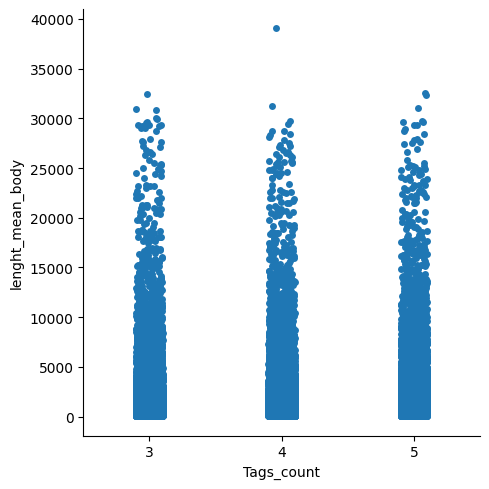

In [49]:
sns.catplot(data=data_global, y="lenght_mean_body", x="Tags_count")

🔍 Idem pour aller plus loin dans l'analyse multivariée, on va devoir nettoyer et preprocesser les données textuelles

## D) Exploration des données textuelles

###  Création des fonctions de nettoyage


In [46]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
def print_sample(sub_df, n_samp=10) :
  '''
  print out n_samp doucments from a corpus
  '''
  samp = sub_df.sample(n_samp)

  for idx, ser in samp.iterrows():
    txt = f"Tags : {ser['Tags']} \n"
    print (txt + ser['Body'] + "..." + "\n\n")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
def remove_html(text):
    """
        Remove the html in sample text
    """
    text = text.replace('\n', '')
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    
    return re.sub(html, "", text)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
def remove_punct(text):
    """
        Remove the punctuation
    """
#     return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)
    return text.translate(str.maketrans('', '', string.punctuation))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
def display_tokens_info(tokens):
  '''display info about corpus
  '''

  print(f"nb tokens {len(tokens)}, nb tokens uniques  {len(set(tokens))}")
  print(tokens[:30])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
def process_text_1(doc, rejoin = False):
  """
  basic function of text processing
  """

  #lower
  doc=doc.lower().strip()

  #nettoyage avec les fonctions précédentes

  doc=remove_URL(doc)

  doc = remove_code(doc)
  #tokenize
  tokenizer = RegexpTokenizer(r"\w+")
  
  raw_tokens_list = tokenizer.tokenize(doc)

  #stop words
  cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

  if rejoin :
    return " ".join(cleaned_tokens_list)

  return cleaned_tokens_list

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
def remove_stopwords(text):
  stop_words = nltk.corpus.stopwords.words('english')
  text = [w for w in text if w not in stop_words]

  return text

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Nettoyage des questions

On a vu que les questions comportaient des extraits de code ainsi que des balises html, on va les supprimer pour pouvoir se concentrer sur les termes techniques permettant d'identifier les tags.

In [56]:
data_global['Body_clear']=data_global['Body'].apply(lambda x:  remove_html(x)) 

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
doc = data_global.Body_clear.sample(10000)
doc = doc.values[5]
doc

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"I'm planning to query large set of data from Firestore database using NodeJS api. Is there any benefit on using stream api (https://cloud.google.com/nodejs/docs/reference/firestore/0.13.x/Query?#stream) instead of reqular query get (https://cloud.google.com/nodejs/docs/reference/firestore/0.13.x/Query?#get)?My impression is that streaming is more efficient in terms of memory consumption.My environment for querying is Firebase functions."

In [58]:
data_global['Body_clear']=data_global['Body_clear'].apply(lambda x:  remove_URL(x)) 

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
data_global['Body_clear'] =data_global['Body_clear'].apply(lambda x: remove_non_ascii(x))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
data_global['Body_clear']  =data_global['Body_clear'].apply(lambda x: remove_punct(x))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
data_global['Body_clear']= data_global['Body_clear'].str.lower()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Tokenization

In [140]:
from nltk.tokenize import WordPunctTokenizer

data_global['Body_tokenized'] = data_global['Body_clear'].apply(word_tokenize)
# ['text_clean'].apply(word_tokenize)
# # Filter out stopwords
# tokens = [tk for tk in tokens if tk not in stopwords.words('english')]


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Lemmatization

In [63]:

lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(word) for word in text]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
#data_global['Body_tokenized'] = data_global['Body_tokenized'].apply(lemmatize_text)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
# selection d'un échantillon de questions 
doc = data_global.Body_tokenized.sample(10000)
doc = doc.values[:5]
doc

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([list(['oddly', 'debug', 'mode', 'script', 'stopped', 'via', 'breakpoint', 'segfault', 'would', 'normally', 'occur', 'without', 'breakpoint', 'resumed', 'segmentation', 'fault', 'happen', 'strange', 'rightthis', 'project', 'us', 'pycharm', 'pygame', 'window', '10', 'project', 'contains', '1500', 'line', 'code', 'across', '8', 'module', 'debugging', 'worked', 'great', 'nowthe', 'segmentation', 'fault', 'doe', 'happen', 'running', 'script', 'normally', 'debug', 'output', 'terminal', 'seg', 'fault', 'occursfatal', 'python', 'error', 'pygameparachute', 'pygame', 'parachute', 'segmentation', 'faultpython', 'runtime', 'state', 'initializedsome', 'thread', 'herethread', '0x0000490c', 'recent', 'call', 'first', 'long', 'stack', 'tracethread', '0x00002c98', 'recent', 'call', 'first', 'long', 'stack', 'tracethread', '0x000048ec', 'recent', 'call', 'first', 'long', 'stack', 'tracecurrent', 'thread', '0x000020d0', 'recent', 'call', 'first', 'file', 'cuserssolairepycharmprojectsgame2aipy', 'l

⛔ On observe que lemmatization entraine des anomalies sur ce jeu de données car elle supprime la marque du pluriel sur des langages et technologies, exemple CSS devient CS ou JS devient J. Afin de conserver l'évolutivité du système (en cas par exemple d'arrivée de nouvelles technos et comme ce sont principalement ces technos qui nous intéressent en mots clés, on n'utilisera pas la lemmatization.

### Suppression des StopWords

In [63]:
#stop_words
stop_words = nltk.corpus.stopwords.words('english')
#newStopWords = ['p','pre', 'blockquote', 'b', 'i', 'strong', 'a', 'ol', 'ul', 'li', 'href', 'https']
#stop_words.extend(newStopWords)
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [143]:
data_global['Body_tokenized']= data_global['Body_tokenized'].apply(lambda x: [word for word in x if word not in stop_words])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [144]:
# selection of a single question
doc = data_global.Body_tokenized.sample(10000)
doc = doc.values[5]
doc

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['trying',
 'use',
 'pure',
 'net',
 'external',
 'classes',
 'controls',
 'helpers',
 'create',
 'saml',
 'message',
 'found',
 'code',
 'interwebs',
 'haveprivate',
 'static',
 'samlassertion',
 'createsamlassertion',
 'create',
 'saml',
 'assertion',
 'id',
 'issuer',
 'name',
 'samlassertion',
 'assertion',
 'new',
 'samlassertion',
 'assertionassertionid',
 'assertionid',
 'assertionissuer',
 'issuer',
 'create',
 'saml',
 'subject',
 'samlsubject',
 'samlsubject',
 'new',
 'samlsubject',
 'samlsubjectname',
 'subject',
 'create',
 'one',
 'saml',
 'attribute',
 'values',
 'samlattribute',
 'attr',
 'new',
 'samlattribute',
 'attrnamespace',
 'attrattributevaluesaddsome',
 'value',
 '1',
 'attrattributevaluesaddsome',
 'value',
 '2',
 'attrname',
 'attr',
 'value',
 'create',
 'saml',
 'statement',
 'containing',
 'one',
 'attribute',
 'one',
 'subject',
 'samlattributestatement',
 'samlattributestatement',
 'new',
 'samlattributestatement',
 'samlattributestatementattributesaddat

In [145]:
# affichage des features nettoyés
valuesTextCleaned = ','.join(str(v) for v in data_global.Body_tokenized)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
wordcloud.generate(valuesTextCleaned)
fig, ax = plt.subplots(1,1, figsize = (9,6))




# add interpolation = bilinear to smooth things out
plt.imshow(wordcloud)


# and remove the axis
plt.axis("off")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

🔍 Après les phases de nettoyage, on voit que les mots courants sont les plus férquents.  Pour mettre en valeur les mots clés on va donc devoir extraire les informations (mots-clés echniques) en tentant de :

1. centrer sur les technos avec le POS (si celles -ci sont dans une catégorie unique par exemple nom)
2.  centrer sur les technos si celles ci sont identifiables avec le NER
3. supprimer les vecteurs les plus fréquents et les plus rares avec le count vectorizer (BOW) et le Term Frequency-Inverse Document Frequency



## E) Extraction d'informations

### 1 -  Essai de Part of Speech 

In [71]:
nltk.download('brown')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [72]:
from nltk.corpus import wordnet
from nltk.corpus import brown

wordnet_map = {"N":wordnet.NOUN, 
               "V":wordnet.VERB, 
               "J":wordnet.ADJ, 
               "R":wordnet.ADV
              }
    
brown_news_tagged  = brown.tagged_sents(categories='news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(brown_news_tagged , backoff=t0)
t2 = nltk.BigramTagger(brown_news_tagged , backoff=t1)

def pos_tag_wordnet(text, pos_tag_type="pos_tag"):
    """
        Create pos_tag with wordnet format
    """
    pos_tagged_text = t2.tag(text)
    
    # map the pos tagging output with wordnet output 
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
    return pos_tagged_text

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
data_global['Pos'] = data_global['Body_tokenized'].apply(lambda x: pos_tag_wordnet(x))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
data_global['Pos'].head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    [(key, n), (difference, n), (cs, n), (transfor...
1    [(trying, v), (run, n), (react, v), (native, n...
2    [(ide, n), (simplifies, n), (creating, v), (sw...
3    [(using, v), (reflection, n), (get, v), (type,...
4    [(java, n), (5, n), (foreach, n), (loop, n), (...
Name: Pos, dtype: object

In [75]:
data_global['Pos'].tail()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


33128    [(im, n), (trying, v), (create, v), (udp, n), ...
33129    [(know, v), (save, v), (model, n), (every, n),...
33130    [(android, n), (studio, n), (321, n), (selectn...
33131    [(perform, v), (inner, a), (leftrightfull, n),...
33132    [(style, n), (defined, n), (reactnative, n), (...
Name: Pos, dtype: object

In [76]:
data_global['Pos'].sample(10)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


20883    [(objectoriented, n), (language, n), (eg, n), ...
17039    [(im, n), (using, v), (macos, n), (mojavei, n)...
6548     [(example, n), (go, v), (wwwyahoocomthispage, ...
2524     [(convert, v), (integer, n), (string42, n), (4...
3234     [(accidentally, r), (pushed, v), (commit, v), ...
23903    [(im, n), (creating, v), (default, n), (concur...
3982     [(using, v), (google, n), (apps, n), (script, ...
11175    [(vue, n), (20, n), (app, n), (let, v), (say, ...
17206    [(want, v), (plot, n), (chart, n), (two, n), (...
11414    [(working, v), (responsive, n), (design, n), (...
Name: Pos, dtype: object

⛔ Certaines  technologies et langages (ex Android, reactnative,etc.) sont considérés comme des noms. D'autres comme des verbes (ex react) . On ne va donc pas pouvoir exploiter le POS sur ce jeu de données.

On peut comparer les résultats obtenus avec ceux qu'on aurait en utilisant spacy (qui permet d'effectuer la tokenization, lemmatization et le morphological flags de chaque token mais aussi le POS et le NER

### 1bis -  Essai de POS avec SpaCy

#### Tokenization avec Spacy


In [77]:
!pip install -U pip setuptools wheel
!pip install -U spacy

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# on va tester sur un pourcentage du DF pour économiser les ressources et accélerer les traitements
data_sample = data_global.sample(frac=0.05, replace=True, random_state=1)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.lang.en import stop_words
nlp = spacy.load("en_core_web_sm")
# # Create a Tokenizer with the default settings for English
# # including punctuation rules and exceptions
data_sample['token_with_spaCy'] = data_sample['Body_clear'].apply(lambda x: nlp(x))


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

In [58]:
data_sample.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,Body_clear,token_with_spaCy
12496,Iterate in RUN command in Dockerfile,<p>I have a line that looks something like: </...,<docker><sh><dockerfile>,39496017,20,45156,0.0,5,i have a line that looks something like run fo...,"(i, have, a, line, that, looks, something, lik..."
23435,Python AND operator on two boolean lists - how?,"<p>I have two boolean lists, e.g.,</p>\n\n<pre...",<python><list><boolean><operator-keyword>,32192163,66,73592,0.0,10,i have two boolean lists egxtruetruefalsefalse...,"(i, have, two, boolean, lists, egxtruetruefals..."
5192,ESLint: Component definition is missing displa...,<p>I'm using a react hook component with antd....,<javascript><reactjs><antd><react-hooks>,55620562,36,63483,0.0,6,im using a react hook component with antd when...,"(i, m, using, a, react, hook, component, with,..."
12004,Illegal instruction (core dumped) mongodb Ubun...,<p>I installed mongodb-org 5.0.2 as per offici...,<mongodb><ubuntu><lts>,68937131,10,19988,0.0,2,i installed mongodborg 502 as per official doc...,"(i, installed, mongodborg, 502, as, per, offic..."
24736,Detecting image URL in C#/.NET,"<p>Is there a way I can detect an image URL, l...",<c#><.net><url><c#-4.0>,11082804,12,11637,0.0,6,is there a way i can detect an image url like ...,"(is, there, a, way, i, can, detect, an, image,..."


In [65]:
spacy_stopwords = nlp.Defaults.stop_words 
data_sample['token_with_spaCy'] = data_sample['token_with_spaCy'].apply(lambda x: [w for w in x if not w.text in spacy_stopwords])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
print(spacy_stopwords)

{'full', 'about', 'thus', 'does', 'whom', 'whereupon', 'hundred', 'besides', 'hers', 'something', 'yours', 'becoming', 'whereby', 'last', 'meanwhile', 'my', 'move', 'per', 'herein', 'anyway', 'with', 'else', 'a', 'anyhow', 'seemed', 'has', 'twenty', 'side', 'some', 'such', 'him', 'however', 'thru', 'she', 'on', '’re', 'ever', 'first', 'was', 'less', 'its', '’m', 'by', 'ten', 'n’t', 'had', 'nobody', 'regarding', 'for', 'four', 'an', 'nowhere', 'own', 'done', 'together', 'empty', 'in', 'quite', 'than', 'almost', 'into', 'wherein', 'six', "'ll", "'d", 'those', 'which', 'herself', 'via', 'seem', 'might', 'part', 'off', 'other', 'down', 'others', 're', 'because', 'hereupon', 'afterwards', 'often', 'give', 'too', 'doing', 'enough', 'i', 'is', 'otherwise', 'namely', 'except', 'that', 'yet', "'re", 'whose', 'became', 'becomes', 'alone', 'any', 'unless', 'latterly', 'moreover', 'next', 'thereupon', 'get', 'show', 'when', 'somewhere', 'say', 'please', 'be', 'nor', 'thereafter', 'have', 'above', 

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
data_sample.head(30)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,Body_clear,token_with_spaCy
12496,Iterate in RUN command in Dockerfile,<p>I have a line that looks something like: </...,<docker><sh><dockerfile>,39496017,20,45156,0.0,5,i have a line that looks something like run fo...,"[line, looks, like, run, x, y, z, echo, donewi..."
23435,Python AND operator on two boolean lists - how?,"<p>I have two boolean lists, e.g.,</p>\n\n<pre...",<python><list><boolean><operator-keyword>,32192163,66,73592,0.0,10,i have two boolean lists egxtruetruefalsefalse...,"[boolean, lists, egxtruetruefalsefalseytruefal..."
5192,ESLint: Component definition is missing displa...,<p>I'm using a react hook component with antd....,<javascript><reactjs><antd><react-hooks>,55620562,36,63483,0.0,6,im using a react hook component with antd when...,"[m, react, hook, component, antd, setting, col..."
12004,Illegal instruction (core dumped) mongodb Ubun...,<p>I installed mongodb-org 5.0.2 as per offici...,<mongodb><ubuntu><lts>,68937131,10,19988,0.0,2,i installed mongodborg 502 as per official doc...,"[installed, mongodborg, 502, official, documen..."
24736,Detecting image URL in C#/.NET,"<p>Is there a way I can detect an image URL, l...",<c#><.net><url><c#-4.0>,11082804,12,11637,0.0,6,is there a way i can detect an image url like ...,"[way, detect, image, url, like, formats, c, ne..."
23216,How can I sort an ArrayList of Strings in Java?,<p>I have <code>String</code>s that are put in...,<java><sorting><arraylist>,13046532,35,116258,0.0,5,i have strings that are put into an arraylist ...,"[strings, arraylist, randomlyprivate, arraylis..."
19076,"Json and Xml serialization, what is better per...",<p>I have to store some config info in file. I...,<c#><xml><json><serialization>,10916591,14,32696,0.0,6,i have to store some config info in file in c ...,"[store, config, info, file, c, code, config, d..."
31540,import error 'force_text' from 'django.utils.e...,<p>I'm implementing a graphql solution using p...,<python><python-3.x><django><graphql><graphene...,70382084,42,40264,0.0,6,im implementing a graphql solution using pytho...,"[m, implementing, graphql, solution, python, g..."
21440,How to extract elements from a matrix using a ...,<p>Suppose I have a matrix <code>A</code> of o...,<python><numpy><matrix><vector><matrix-indexing>,37290879,11,11405,0.0,2,suppose i have a matrix a of order mn and a ve...,"[suppose, matrix, order, mn, vector, order, m1..."
12405,How to use ROW_NUMBER in sqlite,<p>Here is my query given below.</p>\n\n<pre><...,<sqlite><android-sqlite><row-number>,16847574,40,100998,0.0,6,here is my query given belowselect from data ...,"[query, given, belowselect, , data, value, ,..."


In [154]:
data_sample.sample(10)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,Body_clear,token_with_spaCy
4027,Importing custom module into jupyter notebook,"<p>Yes, I know this is a recurrent question bu...",<python><import><jupyter-notebook>,53049195,41,55709,0.0,7,yes i know this is a recurrent question but i ...,"[yes, know, recurrent, question, nt, find, con..."
26839,Expo : com.segment.analytics.android:analytics...,<p>I tried to upload the latest version of my ...,<android><react-native><expo><google-play><goo...,72810081,6,2488,0.0,2,i tried to upload the latest version of my app...,"[tried, upload, latest, version, app, nt, able..."
9637,Python: return the index of the first element ...,<p>The <code>list.index(x)</code> function ret...,<python><list><function><indexing>,1701211,112,87272,0.0,7,the listindexx function returns the index in t...,"[listindexx, function, returns, index, list, i..."
7875,Spring Security: How to use a UserDetailsServi...,"<p>I have a REST service, written using Spring...",<spring><spring-security><oauth-2.0><jwt>,58685218,9,2634,0.0,2,i have a rest service written using spring mvc...,"[rest, service, written, spring, mvc, server, ..."
6165,Javascript Typed Arrays and Endianness,<p>I'm using WebGL to render a binary encoded ...,<javascript><endianness><webgl><typed-arrays><...,7869752,80,42260,0.0,7,im using webgl to render a binary encoded mesh...,"[m, webgl, render, binary, encoded, mesh, file..."
27585,Booting xv6 with qemu,<p>I am trying to boot xv6 with qemu but whene...,<operating-system><qemu><xv6>,70515788,6,1575,NaN,2,i am trying to boot xv6 with qemu but whenever...,"[trying, boot, xv6, qemu, run, qemu, , gettin..."
7108,How to keep a config file when major upgrade i...,<p>I want to keep a config file when the msi i...,<wix><upgrade><preserve>,16186187,15,12837,0.0,5,i want to keep a config file when the msi inst...,"[want, config, file, msi, installer, major, up..."
14825,Is there a dbunit-like framework that doesn't ...,"<p>I was thinking of making a new, light-weigh...",<java><database><testing><scala><dbunit>,3950002,63,28827,0.0,14,i was thinking of making a new lightweight dat...,"[thinking, making, new, lightweight, database,..."
14301,Images border-radius doesn't work during css t...,<p>I'm using <code>border-radius: 50%;</code> ...,<css><hover><blur><flicker>,27934887,10,11091,0.0,5,im using borderradius 50 to make an image roun...,"[m, borderradius, 50, image, round, default, i..."
20575,How to solve a pair of nonlinear equations usi...,<p>What's the (best) way to solve a <strong>pa...,<python><numpy><scipy><sympy>,8739227,89,156418,0.0,9,whats the best way to solve a pair of non line...,"[s, best, way, solve, pair, non, linear, equat..."


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.5, 599.5, 299.5, -0.5)

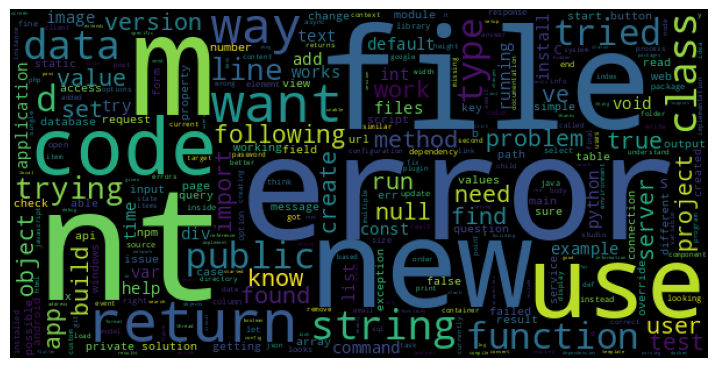

In [147]:
from wordcloud import WordCloud
# affichage des features nettoyés
valuesTextSpacy = ','.join(str(v) for v in data_sample.token_with_spaCy)
wordcloud.generate(valuesTextSpacy)
fig, ax = plt.subplots(1,1, figsize = (9,6))




# add interpolation = bilinear to smooth things out
plt.imshow(wordcloud)


# and remove the axis
plt.axis("off")

#### POS sur un échantillon de questions

In [102]:
questions_sample  = data_global.Body_clear.sample(100)
questions_sample = questions_sample.values[1]
string_questions_sample = ''.join(str(v) for v in questions_sample)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
doc = nlp(string_questions_sample)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


i I PRON PRP nsubj x True True
m m AUX VBP aux x True False
using use VERB VBG ROOT xxxx True True
expressjs expressjs NOUN NN dobj xxxx True False
in in ADP IN prep xx True True
my my PRON PRP$ poss xx True True
code code NOUN NN pobj xxxx True False
with with ADP IN prep xxxx True True
nodejs nodejs ADV RB advmod xxxx True False
v73 v73 NOUN NN pobj xdd False False
in in ADP IN prep xx True True
this this PRON DT pobj xxxx True True
i I PRON PRP nsubj x True True
ve ve AUX VBP aux xx True False
created create VERB VBN ccomp xxxx True False
a a DET DT det x True True
user user NOUN NN compound xxxx True False
router router NOUN NN dobj xxxx True False
which which PRON WDT nsubj xxxx True True
forwards forward VERB VBZ relcl xxxx True False
the the DET DT det xxx True True
requests request NOUN NNS dobj xxxx True False
to to ADP IN prep xx True True
my my PRON PRP$ poss xx True True
user user NOUN NN compound xxxx True False
controllerim controllerim NOUN NN pobj xxxx True False
using 

In [105]:
from spacy import displacy
displacy.render(doc, style='dep', jupyter=True, options={'distance': 130})

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


⛔ nodejs  est considéré comme un adverbe tandis que intellj, controller ou encore login sont  considérés comme des noms.. On ne pourra pas utiliser le POs pour distinguer nos KW

### 2 - Essai de NER avec SpaCy

In [108]:
# sélection d'un échantillon de questions
questions_sample  = data_global.Body_clear.sample(100)
questions_sample = questions_sample.values[:5]
string_questions_sample = ''.join(str(v) for v in questions_sample)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
doc = nlp(string_questions_sample)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
import requests
import spacy
from collections import Counter


# Find all the 'persons' in the text
persons = []
# For each entity in the doc 
for ent in doc.ents:
    # if the entity is a person
    if ent.label_ == 'ORG':
        # add to the list of persons
        persons.append(ent.text)



# list the 12 most common ones
Counter(persons).most_common(12)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('sql', 2)]

In [111]:
for ent in doc.ents:
    print(ent.text, ent.label_)

sql ORG
7 days DATE
sql ORG
getdate7 PERSON
colorbaxsetxlim0 24 FAC
bari PERSON
3public CARDINAL
1 CARDINAL
3 CARDINAL
1 CARDINAL
2 CARDINAL
4 CARDINAL
5 CARDINAL
6 CARDINAL
1204 DATE


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


⛔ l'ENR ne semble pas exploitable pour notre projet. ICi par ex sql  est considéré comme une organisation...

Le POS et l'ENR n'étant pas ici concluant pour classifer nos données. On va utiliser la vectorisation avec des approches comme le BOW et le TFIDF

## F) Vectorization

### 1- Préparation des données pour le BOW

In [11]:
# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_fct(texte) :
    word_clean = remove_URL(texte)
    word_clean = remove_html(word_clean)
    word_clean = remove_non_ascii(word_clean)
    word_clean = remove_punct(word_clean)
    word_clean = word_clean.lower()
    word_tokens = word_tokenize(word_clean)
    filtered_word_tokens = [w for w in word_tokens if not w in stop_words]

    transf_texte = ' '.join(filtered_word_tokens)
    return transf_texte

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cvect = CountVectorizer(strip_accents = 'ascii', lowercase = True, stop_words='english', max_df=0.4, min_df=1)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1 - Frequency vectors - CountVectorizer /bag of Words

In [51]:
# selection d'un echantillon du DD

df_sample_bow = data_global.sample(frac=0.05, replace=True, random_state=42)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
string_questions_sample = ''.join(str(v) for v in df_sample_bow["Body"])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
X=  cvect.fit_transform(df_sample_bow["Body"])


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
vocab = cvect.get_feature_names_out()
docterm = pd.DataFrame(X.todense(), columns=vocab)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
docterm 

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,00,000,0000,00000,000000,0000000,00000000,000000000,0000000000,0000000000000,...,zzib,zzic,zzid,zzie,zzif,zzig,zzsrys4v,zzxpo8pljuv,zzz,zzz0dllquplo1515993694
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5954,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5955,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5957,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TFIDF

In [42]:

# import and instantiate the vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents = 'ascii', lowercase = True, stop_words='english', max_df=0.4, min_df=1)

# apply the vectorizer to the corpus
X = vectorizer.fit_transform(df_sample_bow["Body"])

# display the document-term matrix
vocab = vectorizer.get_feature_names_out()
docterm = pd.DataFrame(X.todense(), columns=vocab)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
docterm

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,00,00 00,00 000,00 0000,00 000000000,00 000z,00 01,00 02,00 03,00 030332,...,zzsrys4v,zzsrys4v 5f6g3niihp6qgp2tgbgrdjfgv6wllc2zye7xet7qfdum8ew5waomrhuy3ufwjbzqqnmefdr9gewxg9n5gougc2ai0tz3zwnpu9rhjrvumo1szgqv,zzxpo8pljuv,zzxpo8pljuv m1b0u,zzz,zzz patientcare,zzz services,zzz zzz,zzz0dllquplo1515993694,zzz0dllquplo1515993694 mp4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


🔍 on obtient des résulats un peu plus précis avec l'approche TF-IDF. On va tester les 2 approches pour voir celle qui  performe le  mieux dans les modèles de ML

🔍 Le vocabulaire 'courant'  alourdit la matrice avec des infos non pertinentes. On a déjà 303 features pour 5 questions. On va donc  réaliser une aCP pour diminer la taille du vocabulaire.

## III - Bag of words (classification)

On va vectoriser nos questions afin qu'elles soient exploitables par les algos de ML

In [52]:
df_sample_bow["Tags_clean"].value_counts()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 node.js  mongodb  mongoose                               8
 ios  swift  swiftui                                      8
 python  pandas  dataframe                                7
 javascript  jquery  html                                 7
 flutter  dart  flutter-layout                            6
                                                         ..
 linux  shell  nginx                                      1
 git  continuous-integration  gitlab  yaml  gitlab-ci     1
 typescript  macos  permissions  plist                    1
 reactjs  .htaccess  react-router  plesk  plesk-onyx      1
 mysql  django  json  fixtures  dumpdata                  1
Name: Tags_clean, Length: 5644, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X = df_sample_bow['Body']
y =df_sample_bow['Tags']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [ ]:
clf = MultinomialNB()

In [ ]:
X=  cvect.fit_transform(df_sample_bow["Body"])